### Imports

In [1]:
import os
import h5py as h5
import json

import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
    
# local imports (found in this repo)
from utils import *
from deconv import *
from releaser import Releaser, mini_releaser
from animator import SacSacAnimator, ball_sticks
from scalebars import add_scalebar

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt
%matplotlib notebook
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "/mnt/Data/NEURONoutput/" + "sac_sac/"
model_path = base_path + "model_runs/"
# load_name = "dist_quanta_50dist_1rep_6s_12t_with_all_trans"  
# load_name = "dist_quanta_50dist_1rep_9s_18t"  
# load_name = "toy_quanta_test"  
# load_name = "dist_quanta_40dist_6s_12t_x2w"  
# load_name = "dist_quanta_40dist_6s_12t_x3w"  
load_name = "dist_quanta_40dist_6s_12t_x2p5w"
rev_name = "dist_quanta_40dist_12s_6t_x2p5w"

In [4]:
with h5.File(os.path.join(model_path, load_name + ".h5"), "r") as f:
    data = {
        int(rep): {
            cond: {
                sac: {
                    metric : f[rep][cond]["data"]["term"][sac][metric][:]
                    for metric in f[rep][cond]["data"]["term"][sac].keys()
                }
                for sac in f[rep][cond]["data"]["term"].keys()
            }
            for cond in f[rep].keys()
        }
        for rep in f.keys()
    }
    first_cond = list(data[0].keys())[0]
    model_params = json.loads(f["0"][first_cond]["model_params"][()])
    exp_params = json.loads(f["0"][first_cond]["exp_params"][()])
    
if rev_name is not None:
    with h5.File(os.path.join(model_path, rev_name + ".h5"), "r") as f:
        rev = {
            int(rep): {
                cond: {
                    sac: {
                        metric : f[rep][cond]["data"]["term"][sac][metric][:]
                        for metric in f[rep][cond]["data"]["term"][sac].keys()
                    }
                    for sac in f[rep][cond]["data"]["term"].keys()
                }
                for cond in f[rep].keys()
            }
            for rep in f.keys()
        }
    
dt = exp_params["dt"]
rec_xaxis = np.arange(0, exp_params["tstop"] + dt, dt)
velocities = exp_params["velocities"]
rec_shape = data[0][first_cond]["a"]["cai"].shape
print("dt = %.2f ms" % dt)
print("recording shape =", rec_shape)

dt = 1.00 ms
recording shape = (1, 10, 6001)


### PN DSi measurements
Here the bar is simply moving in the same direction, over SAC A then SAC B, but we can use the signals in the opposing SACs to calculate a preferred minus null direction selective index.

- **peak:** Using the deflection from the minimum voltage
- **thresh_area:** Area under the voltage above a specified threshold
- **iCa**: Area of calcium current (polarity flipped to positive)
- **gaba:** Area of GABA conductance *applied* the *opposing* SAC  

In [5]:
thresh = -40
dsis = {
    i: { 
        cond: {
            "peak": pn_dsi(
                peak_vm_deflection(exp["a"]["v"]),
                peak_vm_deflection(exp["b"]["v"])
            ),
            "thresh_area": pn_dsi(
                thresholded_area(exp["a"]["v"], thresh),
                thresholded_area(exp["b"]["v"], thresh)
            ),
            "iCa": pn_dsi(
                np.sum(exp["a"]["ica"] * -1, axis=-1),
                np.sum(exp["b"]["ica"] * -1, axis=-1)
            ),
            "peak_[Ca]": pn_dsi(
                np.max(exp["a"]["cai"], axis=-1),
                np.max(exp["b"]["cai"], axis=-1)
            ),
        }
        for cond, exp in es.items()
    } 
    for i, es in data.items()
}

if rev_name is not None:
    for i in rev.keys():
        dsis[i]["no_gaba_rev"] = {
            "peak": pn_dsi(
                peak_vm_deflection(rev[i]["no_gaba"]["a"]["v"]),
                peak_vm_deflection(rev[i]["no_gaba"]["b"]["v"])
            ),
            "thresh_area": pn_dsi(
                thresholded_area(rev[i]["no_gaba"]["a"]["v"], thresh),
                thresholded_area(rev[i]["no_gaba"]["b"]["v"], thresh)
            ),
            "iCa": pn_dsi(
                np.sum(rev[i]["no_gaba"]["a"]["ica"] * -1, axis=-1),
                np.sum(rev[i]["no_gaba"]["b"]["ica"] * -1, axis=-1)
            ),
            "peak_[Ca]": pn_dsi(
                np.max(rev[i]["no_gaba"]["a"]["cai"], axis=-1),
                np.max(rev[i]["no_gaba"]["b"]["cai"], axis=-1)
            ),
        }

dsis = {
    cond: {
        metric: np.concatenate([dsis[i][cond][metric] for i in dsis.keys()], axis=0)
        for metric in dsis[0][cond].keys()
    }
    for cond in dsis[0].keys()
}

In [6]:
print("dsi metric shape =", dsis[first_cond]["peak_[Ca]"].shape)

dsi metric shape = (40, 10)


<IPython.core.display.Javascript object>


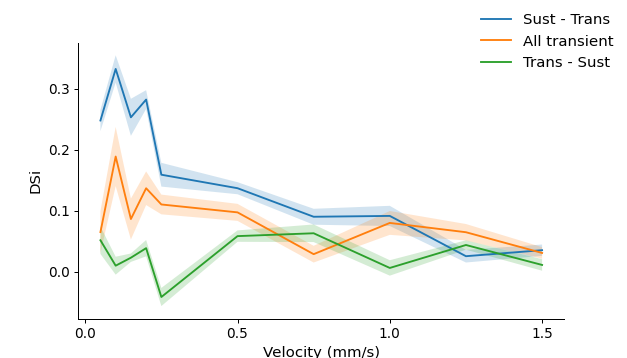

In [10]:
st_no_gaba_mean = np.mean(dsis["no_gaba"]["peak_[Ca]"], axis=0)
st_no_gaba_std = np.std(dsis["no_gaba"]["peak_[Ca]"], axis=0)
st_no_gaba_ste = st_no_gaba_std / np.sqrt(dsis["no_gaba"]["peak_[Ca]"].shape[0])
no_gaba_trans_mean = np.mean(dsis["no_gaba_trans"]["peak_[Ca]"], axis=0)
no_gaba_trans_std = np.std(dsis["no_gaba_trans"]["peak_[Ca]"], axis=0)
no_gaba_trans_ste = no_gaba_trans_std / np.sqrt(dsis["no_gaba_trans"]["peak_[Ca]"].shape[0])

peak_ca_fig, peak_ca_ax = plt.subplots(1, figsize=(7, 4))
peak_ca_ax.fill_between(
    velocities, st_no_gaba_mean + st_no_gaba_ste, st_no_gaba_mean - st_no_gaba_ste, alpha=0.2)
peak_ca_ax.plot(velocities, st_no_gaba_mean, label="Sust - Trans")
peak_ca_ax.fill_between(
    velocities, no_gaba_trans_mean + no_gaba_trans_ste, no_gaba_trans_mean - no_gaba_trans_ste, alpha=0.2)
peak_ca_ax.plot(velocities, no_gaba_trans_mean, label="All transient")

if rev_name is not None:
    ts_no_gaba_mean = np.mean(dsis["no_gaba_rev"]["peak_[Ca]"], axis=0)
    ts_no_gaba_std = np.std(dsis["no_gaba_rev"]["peak_[Ca]"], axis=0)
    ts_no_gaba_ste = ts_no_gaba_std / np.sqrt(dsis["no_gaba_rev"]["peak_[Ca]"].shape[0])
    peak_ca_ax.fill_between(
        velocities, ts_no_gaba_mean + ts_no_gaba_ste, ts_no_gaba_mean - ts_no_gaba_ste, alpha=0.2)
    peak_ca_ax.plot(velocities, ts_no_gaba_mean, label="Trans - Sust")

peak_ca_ax.set_ylabel("DSi", fontsize=12)
peak_ca_ax.set_xlabel("Velocity (mm/s)", fontsize=12)
peak_ca_ax.set_xticks([0., 0.5, 1., 1.5])
# peak_ca_ax.set_yticks([0., 0.15, 0.3])
clean_axes(peak_ca_ax)
peak_ca_fig.legend(fontsize=12, frameon=False)
peak_ca_fig.show()

for ext in [".svg", ".png"]:
    peak_ca_fig.savefig(
        os.path.join(model_path, "velocity_falloff" + ext), bbox_inches="tight")